<a href="https://colab.research.google.com/github/abdishifa234/DS-Unit-2-Applied-Modeling/blob/master/module1-define-ml-problems/LS_DS_231_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

In [78]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [79]:
#import our tools here
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error

In [80]:
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
cf.go_offline()

In [81]:
import plotly.io as pio
pio.renderers.default = 'colab'

In [82]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


###Load the dataset

In [83]:
!pip install gdown

In [84]:
!gdown https://drive.google.com/uc?id=1y0TtYEjkkyuEczM-Jgu6FQfHv1PxOfVG

Downloading...
From: https://drive.google.com/uc?id=1y0TtYEjkkyuEczM-Jgu6FQfHv1PxOfVG
To: /content/archive.zip
15.5MB [00:00, 72.3MB/s]


In [85]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
replace 2014_Financial_Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: 2014_Financial_Data.csv  
replace 2015_Financial_Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: 2015_Financial_Data.csv  
replace 2016_Financial_Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: 2016_Financial_Data.csv  
replace 2017_Financial_Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: 2017_Financial_Data.csv  
replace 2018_Financial_Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: 2018_Financial_Data.csv  


In [118]:
#I have a five year dataset for the display purpose lets read
# Upload datasets and check their shape
pd.options.display.float_format = '{:,.0f}'.format
df_2014 = pd.read_csv('/content/2014_Financial_Data.csv')
df_2015 = pd.read_csv('/content/2015_Financial_Data.csv')
df_2016 = pd.read_csv('/content/2016_Financial_Data.csv')
df_2017 = pd.read_csv('/content/2017_Financial_Data.csv')
df_2018 = pd.read_csv('/content/2018_Financial_Data.csv')

df_2014.shape,df_2015.shape,df_2016.shape,df_2017.shape,df_2018.shape

((3808, 225), (4120, 225), (4797, 225), (4960, 225), (4392, 225))

#Begin to clean and explore your data.
Begin to choose which features, if any, to exclude. Would some features "leak" future information?

In [119]:
#write a function that rangles the dataframes
def wrangle(x):
 
  #renaming the 'Unamed:0' column
  x.rename(columns={'Unnamed: 0':'Company Name'},inplace=True)
  #replacing nan values with zero
  x.replace(np.nan, 0)

  x.drop(x[x['Total assets'] ==0].index, inplace = True) 
  x.drop(x[x['Revenue'] ==0].index, inplace = True) 

  # feature enginering to creat meaningful featutes that determenes stock price
  x['Total Asset Turnover Ratio'] = x['Revenue'] / x['Total assets']
  x['Gross Margin Ratio'] = x['Gross Margin'] / x['Revenue']
  x['Net Profit Ratio'] = x['Net Profit Margin']/x['Revenue']
  x['Return on Total Assets Ratio'] = x['Net Income']/x['Total assets']

  #feature selection
  features = ['Company Name', 'currentRatio','quickRatio', 'Free Cash Flow margin','debtRatio', 'debtEquityRatio',
              'cashFlowToDebtRatio','Return on Tangible Assets','Total Asset Turnover Ratio',
              'Return on Total Assets Ratio','ROE','Gross Margin Ratio',
              'Net Profit Ratio', 'EPS','EPS Diluted','PE ratio', 'PB ratio','priceEarningsToGrowthRatio', 'Sector','Class']
  x = x[features]

  return x


In [146]:
#lets wrangle each dataset and rename our targets which is PriceVar[%]
df2018 = wrangle(df_2018)
df2018['StockPriceVar'] = df_2018['2019 PRICE VAR [%]']
df2017 = wrangle(df_2017)
df2017['StockPriceVar'] = df_2017['2018 PRICE VAR [%]']
df2016 = wrangle(df_2016)
df2016['StockPriceVar'] = df_2016['2017 PRICE VAR [%]']
df2015 = wrangle(df_2015)
df2015['StockPriceVar'] = df_2015['2016 PRICE VAR [%]']
df2014 = wrangle(df_2014)
df2014['StockPriceVar'] = df_2014['2015 PRICE VAR [%]']
df2018.shape, df2017.shape, df2016.shape, df2015.shape, df2014.shape

((4194, 21), (4756, 21), (4588, 21), (3940, 21), (3637, 21))

#Choose which observations you will use to train, validate, and test your model.

Are some observations outliers? Will you exclude them?

Will you do a random split or a time-based split?

The dataset is a time series so it should be splitted based on time but these datas are a 5 year annual csv data and I will use the first three year/2014-2016/ for training,2017 for validation and 2018 for testing dataset

In [147]:
#Option2
#lets arrange our train,val and testing dataset

#use 2014 to 2016 data for training
train = pd.concat([df2014,df2015,df2016],sort=False).drop_duplicates().sample(frac=1)

# train=pd.merge(pd.merge(df2014,df2015,on='Company Name'),df2016,on='Company Name')

#use 2017 data for validation
val=df2017


#use 2017 data for validation
test=df2018


#lets check the shape of our train,val and test dataset
train.shape,val.shape,test.shape

((12165, 21), (4756, 21), (4194, 21))

In [151]:
train.head()

,Company Name,currentRatio,quickRatio,Free Cash Flow margin,debtRatio,debtEquityRatio,cashFlowToDebtRatio,Return on Tangible Assets,Total Asset Turnover Ratio,Return on Total Assets Ratio,ROE,Gross Margin Ratio,Net Profit Ratio,EPS,EPS Diluted,PE ratio,PB ratio,priceEarningsToGrowthRatio,Sector,Class,StockPriceVar
112,IMKTA,2,0,0,1,2,0,0,2,0,0,0,0,3,3,15,2,14,Consumer Defensive,1,28
1831,NAV,1,1,0,1,-1,0,-0,1,-0,0,0,-0,-1,-1,0,0,nan,Industrials,1,35
2278,CXP,5,2,2,0,1,0,nan,0,0,0,0,0,1,1,32,1,29,Real Estate,1,10
4167,AMAT,2,2,0,0,0,1,0,1,0,0,0,0,2,2,19,4,18,Technology,1,62
4356,FSCT,1,1,-0,0,-0,-1,-1,1,-0,0,0,-0,-12,-12,0,0,nan,Technology,1,27


#Choose your target. Which column in your tabular dataset will you predict?

###Notes from the Data Source

1.	The second-to-last column, PRICE VAR [%], lists the percent price variation of each stock for the year. For example, if we consider the dataset 2015_Financial_Data.csv, we will have:
o	200+ financial indicators for the year 2015;
o	percent price variation for the year 2016 (meaning from the first trading day on Jan 2016 to the last trading day on Dec 2016).
	
2.	The last column, class, lists a binary classification for each stock, where
0	for each stock, if the PRICE VAR [%] value is positive, class = 1. From a trading perspective, the 1 identifies those stocks that an hypothetical trader should BUY at the start of the year and sell at the end of the year for a profit.
0	for each stock, if the PRICE VAR [%] value is negative, class = 0. From a trading perspective, the 0 identifies those stocks that an hypothetical trader should NOT BUY, since their value will decrease, meaning a loss of capital.
The columns PRICE VAR [%] and class make possible to use the datasets for both classification and regression tasks:
	
•	If the user wishes to train a machine learning model so that it learns to classify those stocks that in buy-worthy and not buy-worthy, it is possible to get the targets from the class column;
•	If the user wishes to train a machine learning model so that it learns to predict the future value of a stock, it is possible to get the targets from the PRICE VAR [%] column.



###So in this dataset, I have two potential targets,these are "Price Var[%]" and "class" columns.



#Is your problem regression or classification?


###So my plan is to use:

1. "Price Var[%]" for a regression problem b/c it is a countinues variable in order to predict the future value of the stock using linear regression models

2. "Class" for a classification problem b/c it is a categorical variable  in order to classify those stocks that are buy-worthy and not buy-worthy using classification models.

In [91]:
#lets take 2018 dataset
df2018.head()

,Company Name,currentRatio,quickRatio,Free Cash Flow margin,debtRatio,debtEquityRatio,cashFlowToDebtRatio,Return on Tangible Assets,Total Asset Turnover Ratio,Return on Total Assets Ratio,ROE,Gross Margin Ratio,Net Profit Ratio,EPS,EPS Diluted,PE ratio,PB ratio,priceEarningsToGrowthRatio,Sector,Class,2019StockPriceVar
0,CMCSA,1,1,0,0,2,0,0,0,0,0,0,0,3,3,13,2,13,Consumer Cyclical,1,33
1,KMI,1,1,0,0,1,0,0,0,0,0,0,0,1,1,23,1,21,Energy,1,41
2,INTC,2,1,0,0,0,1,0,1,0,0,0,0,5,4,10,3,10,Technology,1,30
3,MU,3,2,0,0,0,4,0,1,0,0,0,0,12,12,4,2,4,Technology,1,64
4,GE,2,1,0,0,3,0,nan,0,-0,-1,0,-0,-3,-3,0,2,nan,Industrials,1,45


#How is your target distributed?
Classification: How many classes? Are the classes imbalanced?



In [92]:
#Lets start with the baseline
target='Class'
y_train=df2018[target]

#see our baseline or majority class of the target Class
df2018['Class'].value_counts()

1    2953
0    1241
Name: Class, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



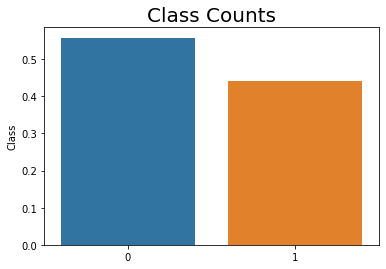

In [93]:
# Plot class distribution
df_class = df['Class'].value_counts(normalize=True)
sns.barplot(np.arange(len(df_class)), df_class)
plt.title('Class Counts', fontsize=20)
plt.show()

Regression: Is the target right-skewed? If so, you may want to log transform the target.

In [94]:
#lets see the regrssion problem targets
#check for outliers for the targets for regression problem
df2018['2019StockPriceVar'].describe()

count   4,194
mean       21
std        59
min      -100
25%        -6
50%        18
75%        40
max     1,286
Name: 2019StockPriceVar, dtype: float64

In [95]:
#lets get ride off price varation greater than 500
df_outlier = df2018.copy()
df_outlier.drop(df_outlier[df_outlier['2019StockPriceVar'] > 500].index, inplace = True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



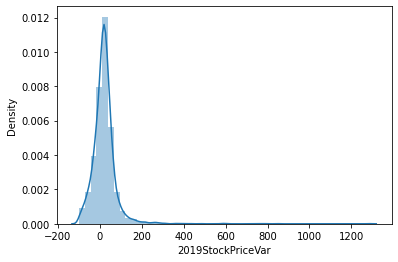

In [96]:
# the target is right-skewed
sns.distplot(df2018['2019StockPriceVar']);

#Choose your evaluation metric(s).

Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?



###So from the above distribution,I have only two class and there is no class imbalance problem since the majority class frequency is b/n 50% and 70%.

In [97]:
#lets see the baseline accuracy of our prediction
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

# lets calculate the majority class accuracy 
accuracy_score(y_train, y_pred)

0.7041010968049595


Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?


Yes, for evaluting the regression,I will use MAE and RMSE

In [98]:
#arranging the y target vectors
target='2019StockPriceVar'
y_train=df2018[target]

In [99]:
#Lets make first baseline for our target PRICE VAR[%]
print('Mean baseline(using 0 features)')
baseline=y_train.mean()
print(baseline)

Mean baseline(using 0 features)
20.60681203287186


In [100]:
#lets see the MAE,RMSE and R2 for the baseline
from sklearn.metrics import mean_absolute_error,r2_score
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
mae=mean_absolute_error(y_train,y_pred)
r2 = r2_score(y_train, y_pred)
print(mse)
print(rmse)
print(mae)
print(r2)

3873.1220923121477
62.23441244450009
38.19300273520961
-0.11019222847668209


Interpretations

#my r2 should be zero becouse it is a baseline with zero features but for some reason it is -0.11

#may be i will plot or visualize the stock price variance based on sectors here